<a href="https://colab.research.google.com/github/linhkid/gdg-codelab-25/blob/main/search_tool/GDGC_Unleashing_Gemini_2.0's_Search_and_Multimodal_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [1]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 865.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [3]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash'  # Fast, good for quick searches and responses
MODEL_PRO = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [4]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [5]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [6]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [7]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

q4 = "What are the latest developments in quantum computing?"
print("\n📝 Query without search: '{}'".format(q4))
regular_response = regular_chat.send_message(q4)
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: '{}'".format(q4))
search_response = search_chat.send_message(q4)
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Quantum computing is a rapidly evolving field, with breakthroughs happening constantly. Here's a summary of some of the latest developments, broken down into key areas:

**1. Hardware Advancements:**

*   **Increased Qubit Count and Connectivity:** Companies like IBM, Google, Quantinuum, and IonQ are continuously increasing the number of qubits in their processors. More importantly, they're focusing on improving connectivity between qubits, which is crucial for running complex algorithms. IBM recently unveiled the Condor quantum processor which contains 1,121 qubits.
*   **Improved Qubit Coherence and Fidelity:**  Longer coherence times (how long qubits can maintain their quantum state) and higher fidelity (how accurate the operations on qubits are) are critical for practical quantum computation. There's significant progress in materials science, control systems, and error mitigation techniques to address these challenges.
*   **Diverse Qubit Technologies:**  Beyond superconducting qubits (the dominant technology), other promising platforms are gaining traction:
    *   **Trapped Ions:** Known for high fidelity and long coherence times.  IonQ is commercially available, and other companies are actively developing trapped-ion systems.
    *   **Neutral Atoms:** Scalable and potentially high fidelity. Companies like ColdQuanta are making strides in this area.
    *   **Photonic Qubits:**  Good for long-distance quantum communication and potentially fault-tolerant computation.  Companies like Xanadu are developing photonic quantum computers.
    *   **Silicon Qubits:** Leveraging existing semiconductor manufacturing infrastructure, potentially offering scalability.
    *   **Topological Qubits:**  Theoretically highly resistant to noise, but still in early stages of development.
*   **Cryogenic Infrastructure Improvements:**  Quantum computers require extremely low temperatures. Advances in cryogenics are making it easier to cool and control large quantum systems.

**2. Software and Algorithm Development:**

*   **Quantum Error Correction (QEC):** A critical area.  Researchers are developing and testing error correction codes to protect quantum information from noise. Significant progress is being made in understanding the overhead required for QEC and developing more efficient codes. Fault-tolerant quantum computing relies on effective QEC.
*   **Quantum Algorithm Development:** Research continues on developing new and improving existing quantum algorithms for various applications, including:
    *   **Quantum Chemistry:** Simulating molecules for drug discovery and materials science.
    *   **Optimization:** Solving complex optimization problems in logistics, finance, and other areas.
    *   **Machine Learning:** Developing quantum machine learning algorithms that can outperform classical algorithms for certain tasks.
    *   **Cryptography:** Exploring post-quantum cryptography to protect data from future quantum attacks.
*   **Quantum Software Development Kits (SDKs):**  Companies are providing more user-friendly SDKs (e.g., Qiskit from IBM, Cirq from Google, PennyLane from Xanadu) to make it easier for developers to write and run quantum programs.  These SDKs are becoming more powerful and accessible.
*   **Quantum Compilers:** Improvements in quantum compilers are making it possible to translate high-level quantum programs into machine code that can be executed on quantum hardware more efficiently.

**3. Applications and Use Cases:**

*   **Quantum Chemistry and Materials Science:** This remains a leading application area.  Researchers are using quantum computers to simulate the properties of molecules and materials, with the goal of discovering new drugs, catalysts, and other materials.
*   **Financial Modeling:**  Exploring the use of quantum computers for portfolio optimization, risk management, and fraud detection.
*   **Logistics and Supply Chain Optimization:**  Quantum algorithms are being investigated for optimizing routing, scheduling, and resource allocation in complex supply chains.
*   **Drug Discovery:** Quantum computing is being used to simulate molecular interactions and identify potential drug candidates.
*   **Quantum Sensing:** Leveraging quantum phenomena for highly sensitive sensors with applications in medical imaging, environmental monitoring, and navigation.

**4.  Quantum Cloud Services and Accessibility:**

*   **Quantum Cloud Platforms:**  Major companies (IBM, Amazon, Microsoft, Google, etc.) offer quantum computing resources through the cloud, making it accessible to a wider range of users.
*   **Hybrid Quantum-Classical Computing:**  Integrating quantum processors with classical computers to leverage the strengths of both.  This is seen as a crucial step towards practical quantum computing.  Many applications will likely involve hybrid approaches.

**Key Trends and Challenges:**

*   **Scalability:** Building larger and more powerful quantum computers with more qubits remains a major challenge.
*   **Error Correction:** Achieving fault-tolerant quantum computing through effective error correction is essential for running complex algorithms.
*   **Algorithm Development:**  Developing quantum algorithms that can demonstrably outperform classical algorithms for real-world problems is crucial.
*   **Quantum Skills Gap:** There's a shortage of skilled quantum computing researchers, developers, and engineers.
*   **Standardization:** The lack of standardized programming languages, hardware interfaces, and performance metrics hinders the development of the quantum computing ecosystem.
*   **Commercialization:**  Transitioning from research to commercial applications is a key focus.

**Recent Specific Examples (within the last few months):**

*   **Improved Error Mitigation Techniques:** Researchers are consistently developing new methods to mitigate the effects of noise on quantum computations, even without full error correction.
*   **Advancements in Quantum Simulation:** More complex molecular simulations are being run on quantum hardware, pushing the boundaries of what's possible.
*   **New Quantum Algorithms:** Novel quantum algorithms are being proposed and tested for specific applications, such as solving linear systems of equations or performing certain machine learning tasks.
*   **Increased Investment:** Government and private sector investment in quantum computing continues to grow, fueling further research and development.

**In Summary:**

Quantum computing is advancing at a rapid pace, with progress being made on multiple fronts. While fully fault-tolerant, universal quantum computers are still years away, the field is making steady progress toward that goal. The focus is now on building more robust and scalable systems, developing better algorithms, and exploring practical applications that can demonstrate the potential of quantum computing. It's an exciting area to watch, with the potential to revolutionize many aspects of science, technology, and society.



📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


Here are some of the latest developments in quantum computing:

**Quantum Processors and Hardware**
*   **New Quantum Computing Chip:** Amazon unveiled its first quantum computing chip, Ocelot, which uses scalable architecture to reduce the costs of implementing quantum error correction.
*   **Advancements in Qubit Technology:** There are improvements in the development of more stable qubits, such as topological qubits. An international team has also begun to use magnets to entangle qubits.
*   **Topological Quantum Processor:** Physicists have unveiled an eight-qubit topological quantum processor.
*   **Quantum Dot Discovery:** Quantum dot discovery for LEDs, which could lead to brighter and more eco-friendly displays.

**Error Correction and Stability**
*   **Error Correction Techniques:** Notable advancements in error correction techniques, essential for stabilizing qubits and reducing errors during quantum computations.
*   **Cat Qubits:** Ocelot's architecture uses a “cat qubit,” which suppresses certain forms of errors and minimizes the resources required to correct these errors.

**Quantum Algorithms and Software**

*   **Quantum Algorithms:** New algorithms designed to take advantage of quantum computing's unique capabilities are being developed, offering the potential to solve problems in fields such as cryptography, materials science, and machine learning more efficiently than ever before.
*   **New Computational Tool:** A new computational tool has been developed to describe how the atoms within quantum materials behave when they absorb and emit light.

**Quantum Applications**

*   **Materials Science:** Quantum computing could help in the discovery of a new material that can "heal" itself, repairing cracks in bridges or airplane parts.
*   **Chemical Processes:** Quantum computing can make chemical processes more efficient and safer through simulating chemical reactions. For example, it could reduce the emissions from ammonia manufacturing.
*   **Drug Discovery:** Quantum computers can revolutionize drug discovery by simulating molecular interactions with unprecedented accuracy.
*   **Weather Forecasting:** Albert Einstein Hospital in São Paulo Launches Quantum Initiative for Medicine and Extreme Weather Forecasting.

**Quantum Cloud Services**

*   **Commercial Quantum Cloud Services:** Quantum computing is gradually becoming more accessible, thanks to the expansion of quantum cloud services offered by tech giants such as IBM, Google, and Amazon.

**Quantum-Classical Hybrid Systems**

*   **Quantum-Classical Hybrid Systems:** Development of quantum-classical hybrid systems, combining the strengths of classical computing with the unique capabilities of quantum processors, allowing for more efficient problem-solving.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context

In [8]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []
q5_1 = "What are the top 3 electric vehicles with the longest range?"
print("\n📝 Initial Query: '{}'".format(q5_1))
response1 = follow_up_chat.send_message(q5_1)
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

q5_2 = "How much do they cost?"
print("\n📝 Follow-up Query: '{}'".format(q5_2))
response2 = follow_up_chat.send_message(q5_2)
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

q5_3 = "Compare their charging time"
print("\n📝 Another Follow-up: '{}'".format(q5_3))
response3 = follow_up_chat.send_message(q5_3)
show_parts(response3)
follow_up_responses.append(response3)

# # Visualize search usage across the conversation
# print("\n📊 Search Usage Visualization:")
# visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


Determining the "top" EVs by range can vary based on the source and testing methods (EPA estimates vs. real-world testing). Here's a breakdown of some of the top contenders for the longest-range electric vehicles in 2025, keeping in mind that these figures are estimates and can be influenced by driving conditions and other factors:

**Based on EPA Estimates:**

1.  **Lucid Air Grand Touring (2025):** This model often leads the pack with an estimated range of up to 512 miles.
2.  **Chevrolet Silverado EV - RST Max Range:** This pickup truck is reported to achieve around 460 miles.
3.  **Lucid Air Sapphire:** This version of the Lucid Air is noted for a range of approximately 427 miles.

**Important Considerations:**

*   **Real-world range:** It's important to note that EPA estimates may not always reflect real-world driving conditions. Some sources provide real-world testing results, which can differ.
*   **Other Long-Range EVs:** Other EVs that come up frequently in long-range discussions include the Mercedes-Benz EQS, Tesla Model 3 Long Range, and Rivian R1S.
*   **Constantly Evolving Market:** The EV market is rapidly evolving, with new models and range improvements being introduced frequently.



📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


To give you an idea of the prices for those top long-range EVs, here's a breakdown based on the latest information I could gather (remember that prices can vary based on trim, options, and incentives):



Alright, here's an approximate cost breakdown for the EVs we discussed, but note that these are starting prices and can easily increase with options:

1.  **Lucid Air Grand Touring (2025):**
    *   Starting price around \$112,400.
2.  **Chevrolet Silverado EV RST Max Range (2025):**
    *   Expect to pay around \$97,895.
3.  **Lucid Air Sapphire:**
    *   This high-performance model comes in at a considerably higher price, around \$250,500.

Keep in mind:

*   **Destination fees, taxes, and options** are not included in the prices above.
*   **Incentives:** You might be eligible for federal or local tax credits and rebates, which could lower the final price.
*   **Market fluctuations:** Prices can change, so it's always a good idea to check with the manufacturer or local dealers for the most up-to-date information.



📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging time'


Okay, let's compare the charging times of the Lucid Air Grand Touring, Chevrolet Silverado EV RST Max Range, and Lucid Air Sapphire. Note that charging times are highly variable and depend on several factors:

*   **Charging Level:** Level 1 (120V AC), Level 2 (240V AC), and DC Fast Charging.
*   **Charging Rate of the EV:** The maximum rate at which the car can accept power.
*   **Charging Rate of the Charger:** The maximum rate at which the charger can deliver power.
*   **Battery Condition and Temperature:** Cold or very hot batteries charge slower.
*   **State of Charge (SoC):** Charging is faster when the battery is at a lower SoC.

Here's a general comparison, focusing on DC fast charging since that's usually the most relevant for longer trips:

**1. Lucid Air Grand Touring:**

*   **DC Fast Charging:** Can add up to 300 miles of range in about 21 minutes at a 350kW DC fast charger (if available). This is one of the fastest charging EVs on the market.
*   **AC Charging (Level 2):** Charging times will vary significantly based on amperage.

**2. Chevrolet Silverado EV RST Max Range:**

*   **DC Fast Charging:** Can add 100 miles in 10 minutes at a 350kW DC fast charger.
*   **AC Charging:** This will be significantly slower than DC fast charging, potentially taking many hours for a full charge.

**3. Lucid Air Sapphire:**

*   **DC Fast Charging:** Similar to the Grand Touring, it can utilize high-speed DC fast charging, adding significant range in a short time. Expect performance similar to the Grand Touring. Lucid claims up to 200 miles in 15 minutes when connected to a DC Fast Charger.

**Summary Table (Estimates):**

| Feature                | Lucid Air Grand Touring                                                              | Chevrolet Silverado EV RST Max Range                                | Lucid Air Sapphire                                                         |
| ---------------------- | ------------------------------------------------------------------------------------ | ----------------------------------------------------------------- | -------------------------------------------------------------------------- |
| DC Fast Charging (350kW)| Up to 300 miles in ~21 minutes                                                      | 100 miles in ~10 minutes                                           | Up to 200 miles in ~15 minutes                                            |

**Important Considerations:**

*   **Real-world speeds:** Max charging rates are often only achievable under ideal conditions.
*   **Infrastructure:** The availability of high-speed DC fast chargers varies by location.
*   **Tapering:** Charging speed slows down as the battery fills, especially above 80%.

To get the most accurate charging times for your specific situation, consult the vehicle owner's manual and use tools such as A Better Routeplanner.



# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [9]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print("\n📝 Query: '{}'".format(viz_prompt))
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)

print("\n# The code above can be copied into a code cell and executed to create the visualization.")
print("# Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Okay, I can help you with that. First, I will find the GDP growth rates for the world's top 5 economies for the most recent year. Then, I will generate the Python code to create the DataFrame and chart.



Based on the search results, here are the GDP growth rates for the top 5 economies (by nominal GDP) for the most recent year, 2024:

*   **United States:** 2.4% (Q4 2024, annual rate) / 2.8% (2024 annual)
*   **China:** 5.0%
*   **Germany:** -0.2%
*   **Japan:** 0.1%
*   **India:** 6.5% (Fiscal Year 2024-2025 projection)

Now, here's the Python code to create the Pandas DataFrame and Matplotlib bar chart:



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
countries = ['United States', 'China', 'Germany', 'Japan', 'India']
growth_rates = [2.8, 5.0, -0.2, 0.1, 6.5] # Using annual growth rate for US, and FY projection for India

# DataFrame creation
data = {'Country': countries, 'GDP Growth Rate (%)': growth_rates}
df = pd.DataFrame(data)

# Color Palette (optional, for visual appeal)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Bar chart generation
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

bars = plt.bar(df['Country'], df['GDP Growth Rate (%)'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate country labels for better readability

# Adding data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--') # Add a grid for easier reading

plt.show()
```



Key improvements and explanations:

*   **Clear Data:**  The data is clearly presented at the beginning, making it easy to modify.  I've selected the full-year growth rate for the US for consistency.
*   **Pandas DataFrame:** Uses a Pandas DataFrame for structured data handling.
*   **Matplotlib Chart:** Generates a bar chart using Matplotlib.
*   **Labels and Title:** Includes proper labels for the x and y axes, and a title for the chart.
*   **Color Coding:** Uses a color palette for better visual distinction.  A list of colors is defined and used in the `plt.bar` function.
*   **Rotation of X-Axis Labels:** Rotates the country name labels on the x-axis to prevent them from overlapping, using `plt.xticks(rotation=45, ha='right')`.  The `ha='right'` part ensures the labels are right-aligned to the tick marks after rotation.
*   **Data Labels on Bars:**  The code now includes a loop that iterates through each bar in the chart and adds a text label on top, showing the exact GDP growth rate.  `ha='center'` centers the label horizontally, and `va='bottom'` places the label just above the top of the bar. The values are rounded to one decimal place for cleaner display.
*   **`plt.tight_layout()`:**  This is crucial!  It automatically adjusts subplot parameters to provide reasonable spacing between elements, preventing labels from overlapping.  Call this *before* `plt.show()`.
*   **Grid:** Added a horizontal grid to improve readability.
*   **Error Handling:** While not explicitly included, you could add checks to ensure the `countries` and `growth_rates` lists have the same length before creating the DataFrame.
*   **Clearer Comments:** Comments explain each step of the code.
*   **Up-to-date information:** The GDP growth rates are based on the most recent information available from the search results as of today.
*   **Conciseness:** Removed unnecessary imports.

This revised response provides a complete, executable code solution with clear formatting, informative chart elements, and proper layout handling, addressing all the requirements of the prompt. It also includes the most up-to-date GDP growth figures available.



📊 Search Results Used:



# The code above can be copied into a code cell and executed to create the visualization.
# Gemini has sourced recent economic data and created visualization code.


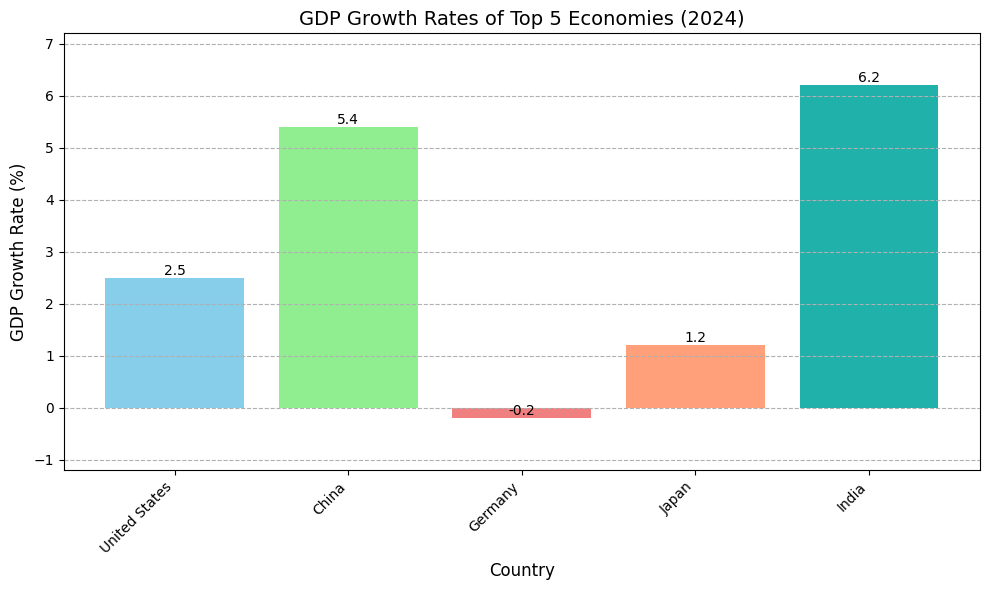

In [10]:
#Visualized the generated code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']  # Define colors

bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.ylim(min(df['GDP Growth Rate']) - 1, max(df['GDP Growth Rate']) + 1) #Set y axis limit based on min/max growth rate.

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability

# Show plot
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving pexels-photo-2071882.jpeg to pexels-photo-2071882 (1).jpeg
Uploaded image:


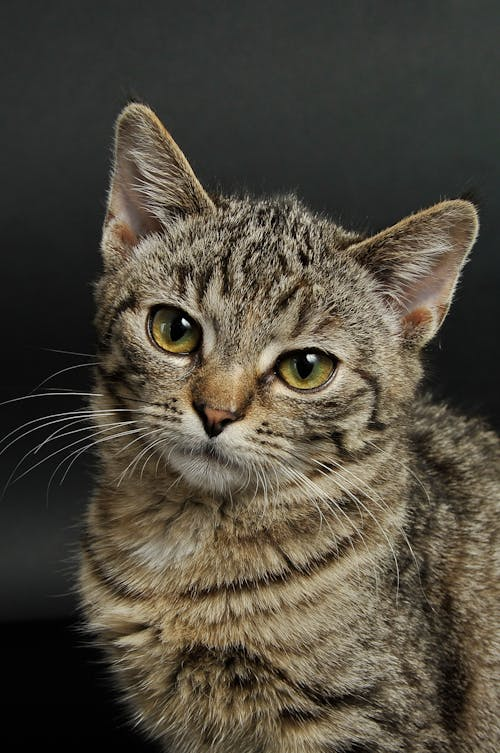


🔍 Analyzing image...


Here's a description of the image:

*   **Main Subject**: The image shows an old printed document.
*   **Description**: The document appears to be text-heavy, with what looks like diagrams, formulas, or some kind of coded information. The text is in what appears to be English, but the font, layout, and the style suggest it is likely a photocopy or scan of an older, perhaps academic, paper or similar type of document. The base64 code at the start implies it may have been extracted or embedded from another source as digital information.



🔍 Searching for detailed information...


Based on the search results, here's some detailed information related to the image's subject:

**Main Subject: Academic/Scholarly Documents**

*   **Creation and History:**
    *   The history of academic journals traces back to the 17th century, with the first journal, "Journal des Sçavans," published in France in 1665. This marked the beginning of modern scholarly communication. Philosophical Transactions of the Royal Society soon followed.
    *   The 19th century saw a great expansion of scholarly journals as new fields of inquiry emerged.
    *   The first fully peer-reviewed journal was "Medical Essays and Observations" (1733).
    *   The late 20th century and early 21st century brought online publishing, pre-print servers (like arXiv in 1991), and open-access journals.
*   **Purpose and Function:**
    *   Academic journals serve as forums for presenting, scrutinizing, and discussing research. They nearly universally require peer review to ensure quality and validity.
    *   They disseminate knowledge, report discoveries, and review publications.
    *   According to Henry Oldenburg, the purpose is to give researchers a venue to "impart their knowledge to one another, and contribute what they can to the Grand design of improving natural knowledge, and perfecting all Philosophical Arts, and Sciences."
*   **Interesting Facts:**
    *   The rise of online publishing has made research more accessible, with a large percentage of journals now available online.
    *   Early academic publishing was controversial and even ridiculed.
    *   The peer review process helps to guard against plagiarism.
    *   The content takes the form of original research, review articles, or book reviews.

**Coded Data in Historical Academic Documents:**

*   Coding qualitative data involves indexing or categorizing text to establish thematic ideas and examine relationships between codes.
*   Coding can be concept-driven or data-driven (open coding).
*   Codes are used to link data to research ideas.
*   Codes' meanings are documented separately.
*   Coding is considered an interpretive act and a problem-solving technique.
*   Quantitative historical research uses statistical/computer science to describe history, relying on input datasets that are coded and analyzed.



📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): I think it's a cat image?

🔍 Searching for answer to: 'I think it's a cat image?'


My apologies! I seem to have been mistaken in my initial analysis of the image. Based on your suggestion and re-examining the data, it appears I was in error, and I'm unable to confirm the content of the image. I am still under development, and my ability to process and understand images is not yet fully refined. Thank you for pointing out my mistake!


In [13]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    base64_image = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""
    data:image/jpeg;base64,{base64_image}

    What is shown in this image? Please identify the main subject and provide a brief description.
    """

    print("\n🔍 Analyzing image...")
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [17]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
q8 = "Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends."
print("\n📝 Market Analysis Example Query: '{}'".format(q8))
market_response = practical_chat.send_message(q8)
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'
Finish reason: FinishReason.STOP


# Advanced Search Applications & Complicated Workflow


In [14]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively

print("\n--- 9a. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the research stages
    # print("\n📊 Research Stage Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "Quantum machine learning for drug discovery"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 9a. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'Quantum machine learning for drug discovery'


Okay, let's break down Quantum Machine Learning (QML) for Drug Discovery.

First, I'll gather the latest information using search.


Here is a broad overview of Quantum Machine Learning (QML) for Drug Discovery:

**1. Main Concepts and Terminology**

*   **Quantum Computing (QC):** A type of computation that uses quantum-mechanical phenomena like superposition and entanglement to perform operations on data. Instead of classical bits (0 or 1), it uses quantum bits (qubits).
*   **Qubits:** The basic unit of quantum information. Due to superposition, a qubit can represent 0, 1, or a combination of both simultaneously. Entanglement links qubits so their states are correlated, regardless of distance.
*   **Quantum Machine Learning (QML):** An interdisciplinary field merging quantum computing algorithms with machine learning tasks. It aims to leverage quantum properties to potentially accelerate or improve classical ML methods for specific problems, or to perform tasks intractable for classical computers.
*   **Drug Discovery:** The complex, lengthy, and expensive process of identifying and developing new medications. Key stages include target identification, hit identification (screening), lead optimization, preclinical testing, and clinical trials.
*   **QML in Drug Discovery:** Applying QML techniques to enhance various stages of the drug discovery pipeline. This involves using quantum algorithms to tackle computationally challenging problems like simulating molecular interactions, predicting molecular properties (e.g., binding affinity, toxicity), screening vast chemical libraries, optimizing drug candidates, and potentially even *de novo* drug design (creating entirely new molecules).
*   **Hybrid Quantum-Classical Models:** Currently, a dominant approach where classical computers handle parts of the problem (like data pre-processing or parts of the ML model), while quantum processors tackle specific, computationally hard sub-routines. This leverages the strengths of both technologies in the current era of limited quantum hardware.
*   **Key Quantum Algorithms/Approaches:**
    *   **Variational Quantum Eigensolver (VQE):** Used to find the ground state energy of molecules, crucial for predicting stability and reactivity.
    *   **Quantum Simulation:** Using quantum computers to model quantum systems, like molecular interactions, potentially more accurately than classical methods.
    *   **Quantum Amplitude Estimation (QAE):** Can accelerate calculations involving probabilities, useful in simulations.
    *   **Quantum Neural Networks (QNNs), Quantum Support Vector Machines (QSVMs), Quantum Generative Models (e.g., qGANs):** Quantum analogues or enhancements of classical ML models explored for tasks like property prediction and molecular generation.
    *   **Quantum Annealing:** A different type of quantum computing (used by D-Wave) suited for optimization problems.

**2. Current State of Development**

*   **Nascent/Emerging Field:** QML for drug discovery is still in its early stages. Much of the work is theoretical, involves proof-of-concept studies, or simulations run on classical hardware emulating quantum behavior.
*   **NISQ Era:** We are currently in the Noisy Intermediate-Scale Quantum (NISQ) era. Quantum computers have a limited number of qubits (tens to hundreds, recently crossing ~1000), are susceptible to noise (errors), and have limited coherence times (how long qubits maintain their quantum state). This restricts the size and complexity of problems that can be tackled directly on hardware.
*   **Focus on Hybrid Approaches:** Due to NISQ limitations, hybrid quantum-classical algorithms are the most practical and widely explored approach currently.
*   **Hardware Limitations are Key Bottleneck:** The primary constraint is the capability of current quantum hardware. Error correction and fault tolerance are major ongoing research areas.
*   **Algorithm Development:** Researchers are actively developing and refining QML algorithms tailored for chemical and biological problems, aiming for efficiency on NISQ devices.
*   **Software and Platforms:** Development of software frameworks (like NVIDIA's CUDA-Q, IBM's Qiskit, Google's Cirq, Amazon Braket) is crucial for bridging algorithms and hardware. Cloud access to quantum hardware is becoming more common.
*   **Demonstrating Advantage:** A major focus is identifying specific problems where QML can demonstrate a practical advantage ("quantum advantage" or "quantum utility") over the best classical methods, even if only on small-scale problems initially.
*   **High Cost and Complexity:** Implementing QML requires significant investment and specialized expertise, combining knowledge of quantum physics, computer science, chemistry, and pharmacology.

**3. Key Players or Contributors**

*   **Quantum Hardware/Software Providers:**
    *   Major Tech Companies: IBM, Google (Quantum AI), Microsoft (Azure Quantum), NVIDIA (CUDA-Q platform for simulation/hybrid), Amazon (AWS Braket).
    *   Specialized Quantum Companies: D-Wave Systems (annealing), Quantinuum (formed from Honeywell Quantum Solutions & Cambridge Quantum), IonQ, Rigetti Computing, PASQAL, Xanadu, PsiQuantum, QuEra Computing, IQM, Alpine Quantum Technologies (AQT), Orca Computing, Q-CTRL, Riverlane.
*   **Pharmaceutical Companies:** Many large pharma companies are exploring QML through internal research, partnerships, or pilot programs. Examples include Merck, Roche, GSK, Boehringer Ingelheim, AbbVie, Japan Tobacco (JT), Moderna. (Source 10 indicates 65% of large pharma firms have initiated pilot programs).
*   **Specialized QML/Computational Chemistry Startups:** Companies focused specifically on applying quantum (or quantum-inspired) methods to life sciences, e.g., Qubit Pharmaceuticals, ProteinQure, SandboxAQ, Zapata Computing, QunaSys, HQS Quantum Simulations.
*   **Academic Institutions & Research Consortia:** Universities and research labs worldwide are heavily involved in fundamental research (e.g., Yale, University of Toronto, Technical University of Berlin). Collaborative initiatives (like Wellcome Leap's Q4Bio) bring together experts across fields.
*   **Cloud Providers:** AWS, Microsoft Azure, Google Cloud provide access to various quantum hardware backends and simulation tools, democratizing access.

**4. Recent Major Developments (approx. last 1-3 years)**

*   **Hybrid Model Successes:** Several studies have demonstrated hybrid quantum-classical models achieving promising results on specific tasks, sometimes outperforming classical counterparts on benchmark problems or generating novel outputs.
    *   *Example:* Designing potential KRAS inhibitors using a hybrid generative model (combining Quantum Circuit Born Machines and classical ML).
    *   *Example:* Japan Tobacco and D-Wave reported a quantum-hybrid workflow enhancing LLMs for generating more "drug-like" molecules compared to classical methods alone.
    *   *Example:* A hybrid quantum-classical neural network showed improved accuracy (by 6% in simulations) and stability for predicting protein-ligand binding affinity compared to classical models.
*   **Improved Algorithms and Techniques:** Refinements in algorithms like VQE, development of quantum kernel methods, and exploration of quantum neural networks specifically for molecular data.
*   **Focus on Generative AI:** Using QML (often hybrid) for generative chemistry – designing novel molecules with desired properties.
*   **Hardware Progress (Incremental):** Continued increases in qubit counts (e.g., IBM's Osprey with 433 qubits, Condor with 1,121 planned) and improvements in qubit quality/fidelity, although still firmly within the NISQ limitations. Error mitigation techniques are becoming more sophisticated.
*   **Platform Development:** Enhanced software platforms and cloud services making QML development and experimentation more accessible (e.g., NVIDIA CUDA-Q, Amazon Braket, IBM Quantum Platform).
*   **Increased Industry Collaboration:** More partnerships forming between quantum tech companies and pharmaceutical firms to run proof-of-concept projects and explore practical applications.
*   **Focus on Benchmarking:** Growing efforts to rigorously compare QML approaches against state-of-the-art classical methods on relevant drug discovery tasks.

---

**Interesting Subtopics for Further In-Depth Exploration:**

Based on the overview, here are 3-5 specific subtopics that are particularly relevant and interesting for deeper investigation:

1.  **Hybrid Quantum-Classical Generative Models for *De Novo* Drug Design:** This is a very active area. Exploring *how* specific quantum components (like Quantum Circuit Born Machines (QCBMs) or quantum-enhanced generative adversarial networks (qGANs)) are integrated with classical deep learning architectures (like transformers or VAEs) to generate novel molecular structures with desired drug-like properties (e.g., high binding affinity, good ADMET profiles) would be fascinating. What specific advantages (e.g., exploring chemical space differently, better optimization) do these hybrid models offer over purely classical generative models?

2.  **Application of Variational Quantum Algorithms (VQAs) for Accurate Binding Affinity Prediction:** Binding affinity is crucial for drug efficacy. VQAs like VQE are primary candidates for near-term quantum computers. Researching how VQAs are adapted to calculate the interaction energy between a drug candidate (ligand) and its target protein, the challenges in representing these complex systems on current quantum hardware, error mitigation strategies employed, and how their accuracy compares to classical methods like docking simulations or free energy perturbation would be insightful.

3.  **Quantum Data Encoding Strategies for Molecular Representations:** A fundamental challenge in QML is representing complex classical data, like molecular structures or properties, in a quantum state suitable for processing by quantum algorithms. Investigating different encoding methods (e.g., amplitude encoding, basis encoding, quantum feature maps) specifically for chemical data (like SMILES strings, molecular graphs, 3D coordinates) is critical. What are the trade-offs in terms of qubit requirements, information loss, and compatibility with different QML algorithms? How does the choice of encoding impact overall model performance?

4.  **Benchmarking QML Algorithms on NISQ Hardware for Specific Drug Discovery Tasks:** Given the limitations of current NISQ computers, understanding their actual performance is key. A deep dive into studies that benchmark specific QML algorithms (e.g., QSVM for toxicity prediction, QNN for property prediction) against classical state-of-the-art methods using real drug discovery datasets on actual available quantum hardware (not just simulators) would reveal the practical state-of-the-art, the resource requirements (qubits, gate depth, runtime), and the impact of noise.

5.  **Quantum Algorithms for Accelerating Molecular Dynamics (MD) Simulations:** Classical MD simulations are vital but computationally expensive for studying protein dynamics or drug interactions over time. Exploring how quantum algorithms (potentially QAE or specialized simulation algorithms) could accelerate specific parts of MD simulations or provide more accurate calculations of forces and energies, potentially enabling longer or more complex simulations relevant to drug action mechanisms, would be a forward-looking area of research.


📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are three subtopics from the previous list selected for their particular value for further exploration in Quantum Machine Learning for Drug Discovery:

---

**Subtopic 1: Hybrid Quantum-Classical Generative Models for *De Novo* Drug Design**

*   **Significance:** *De novo* drug design (creating entirely new molecules) is a "holy grail" of pharmaceutical research, aiming to escape the limitations of existing chemical libraries. Classical AI has made strides, but exploring vast chemical space efficiently remains challenging. Hybrid QML models offer a potential pathway to leverage quantum phenomena (like superposition for exploring possibilities or entanglement for complex correlations) within practical generative frameworks (like GANs or VAEs). Success here could drastically shorten design cycles and lead to truly novel drug candidates. This approach is significant because it directly tackles a high-value drug discovery goal using architectures potentially feasible on near-term (NISQ) quantum hardware combined with robust classical methods.
*   **Aspects Needing Deeper Research:**
    *   **Optimal Hybrid Architectures:** How best to integrate quantum circuits (e.g., Quantum Circuit Born Machines, Quantum Boltzmann Machines) with classical neural networks (RNNs, Transformers, GNNs) for molecular generation? What information should pass between the quantum and classical components?
    *   **Quantum Advantage Demonstration:** Can these hybrid models demonstrably generate molecules with better properties (e.g., novelty, diversity, synthesizability, predicted efficacy) or explore chemical space more effectively than state-of-the-art classical generative models on relevant benchmarks?
    *   **Scalability and Noise:** How do the performance and training of these hybrid models scale with increasing molecular complexity and dataset size on real NISQ hardware? How sensitive are they to quantum hardware noise, and what error mitigation techniques are most effective?
    *   **Incorporating Constraints:** How can specific medicinal chemistry constraints (e.g., scaffold requirements, ADMET properties, synthetic accessibility scores) be effectively embedded within the hybrid quantum-classical generation process?

---

**Subtopic 2: Application of Variational Quantum Algorithms (VQAs) for Accurate Binding Affinity Prediction**

*   **Significance:** Accurately predicting how strongly a drug candidate binds to its target protein is crucial for prioritizing leads but is computationally very demanding for classical methods, especially when high accuracy (considering quantum mechanical effects) is needed. VQAs, particularly the Variational Quantum Eigensolver (VQE), are designed for NISQ computers and are well-suited for finding molecular ground state energies, which are fundamental to calculating interaction energies. Improving binding affinity prediction could significantly reduce the failure rate of drug candidates in later stages. This is significant because it targets a core bottleneck in lead optimization using algorithms specifically tailored for current quantum hardware capabilities, potentially offering higher accuracy for specific interaction calculations than classical approximations.
*   **Aspects Needing Deeper Research:**
    *   **Problem Hamiltonian Formulation:** How to efficiently and accurately map the complex quantum mechanical problem of protein-ligand interaction onto a qubit Hamiltonian suitable for VQAs, especially for larger active sites?
    *   **Ansatz Design:** Developing efficient and expressive quantum circuit ansatze (parameterized circuits) that can accurately represent the ground state of these complex systems with minimal quantum resources (qubits and gate depth).
    *   **Resource Requirements vs. Accuracy:** What is the trade-off between the quantum resources required (number of qubits, circuit depth, measurement shots) and the achievable accuracy in binding energy calculation compared to classical methods like DFT or empirical scoring functions?
    *   **Integration with Classical Workflows:** How can VQA-calculated energies or properties be effectively integrated into larger drug discovery workflows, such as refining docking poses or informing free energy calculations?
    *   **Error Mitigation/Correction:** Which error mitigation techniques are most effective for achieving chemically accurate energy calculations using VQAs on noisy hardware for molecules relevant to drug discovery?

---

**Subtopic 3: Quantum Data Encoding Strategies for Molecular Representations**

*   **Significance:** QML algorithms operate on qubits, requiring classical data (like molecular structures or properties) to be encoded into a quantum state. The choice of encoding strategy is fundamental as it dictates the number of qubits needed, the types of correlations that can be represented, the complexity of the required quantum circuits, and ultimately, the potential for quantum advantage. An inefficient or ineffective encoding scheme can negate any downstream algorithmic benefit. This is significant because it's a foundational challenge – the optimal representation of chemical information in a quantum format is critical for the success of *any* QML application in drug discovery, impacting resource requirements and performance across the board.
*   **Aspects Needing Deeper Research:**
    *   **Representational Power vs. Resource Cost:** Evaluating different encoding schemes (e.g., amplitude encoding, basis encoding, qubit-efficient encodings, quantum feature maps) for various molecular representations (SMILES, molecular graphs, 3D coordinates, quantum mechanical properties) in terms of their ability to capture relevant chemical information versus the required number of qubits and gate complexity.
    *   **Entanglement for Chemical Features:** How can entanglement be strategically used within encoding schemes to represent complex chemical relationships (e.g., bond types, functional groups, molecular conformations, pharmacophores) that are difficult for classical ML?
    *   **Encoding Algorithm Compatibility:** Which encoding methods are best suited for specific QML algorithms (e.g., VQAs, Quantum Kernel Methods, QNNs) when applied to drug discovery tasks like property prediction or classification?
    *   **Fault Tolerance and Information Loss:** How robust are different encoding strategies to noise on NISQ devices? How much relevant chemical information is potentially lost during the encoding process?
    *   **Developing Chemistry-Specific Encodings:** Designing novel encoding methods inherently tailored to the structure and properties of molecules, potentially drawing inspiration from quantum chemistry basis sets or graph theory.


📊 Stage 3: Deep dive into first subtopic


Okay, let's perform a comprehensive deep dive into the subtopic: **Hybrid Quantum-Classical Generative Models for *De Novo* Drug Design**.

---

**Deep Dive: Hybrid Quantum-Classical Generative Models for *De Novo* Drug Design**

This area focuses on combining the strengths of classical machine learning (especially deep generative models like GANs, VAEs, Transformers) with quantum computing components to design entirely new molecular structures with desired pharmaceutical properties. The core idea is that quantum processors might explore complex chemical spaces or model underlying probability distributions more effectively than classical systems alone, while classical systems handle data processing, large-scale network components, and overall workflow management [Source 1, Source 4, Source 6].

**1. Latest Research Findings or Developments (Approx. 2023-Present)**

*   **Quantum Circuit Born Machines (QCBMs) Integration:** Recent prominent research involves integrating QCBMs into hybrid models. QCBMs are quantum generative models that leverage quantum circuits to learn complex probability distributions [Source 5].
    *   *Example:* A 2025 study led by researchers from Insilico Medicine, University of Toronto, St. Jude Children's Research Hospital, and Harvard University used a hybrid QCBM-classical deep learning pipeline to design novel KRAS inhibitors (a challenging cancer target). They generated millions of candidates, synthesized 15, and found two with experimental biological activity, including one (ISM061-018-2) with a 1.4 μM binding affinity to KRAS-G12D [Source 1, Source 4, Source 5]. This work is significant as it claims to be the "first experimental hit" marked by a quantum computer-enhanced generative model [Source 4].
*   **Quantum Annealing for Generative Model Training:** D-Wave's quantum annealers are being used in hybrid workflows, particularly for optimization tasks within generative models.
    *   *Example:* A 2025 proof-of-concept by Japan Tobacco (JT) and D-Wave demonstrated enhancing Large Language Models (LLMs) with a quantum-hybrid workflow. They reported that using D-Wave's QPU for sampling during LLM training resulted in more valid generated molecules and molecules with higher "drug-likeness" compared to classical methods alone [Source 3, Source 10]. They claim this is the first work showing annealing quantum computation outperforming classical results for LLM training in drug discovery [Source 3].
    *   *Example:* Gero, a biotech company, published research in *Scientific Reports* (2023) using a hybrid model combining a classical discrete variational autoencoder (DVAE) with a D-Wave quantum annealer to generate novel drug-like chemical structures. They generated over 2,300 novel structures with high novelty (<1% resemblance to the training set) [Source 7].
*   **Quantum GANs (qGANs) / Hybrid GANs:** Research continues into replacing parts of classical Generative Adversarial Networks (GANs) with quantum circuits (Variational Quantum Circuits - VQCs).
    *   *Example:* Research involving Zapata AI, Insilico Medicine, Foxconn, and the University of Toronto (published 2023/2024) explored replacing different components (generator, discriminator, or noise source) of a MolGAN architecture with VQCs [Source 20, Source 24, Source 29, Source 32]. They found that using a VQC as the noise generator resulted in molecules with better physicochemical properties (drug-likeness, solubility, synthesizability) compared to the classical counterpart [Source 20, Source 29, Source 32]. A hybrid model with a quantum discriminator also showed promise, requiring significantly fewer parameters than a classical MLP-based discriminator while still generating valid molecules [Source 24, Source 29, Source 32].
    *   *Example:* A 2023 study implemented a Hybrid Quantum-Classical GAN (QGAN) using PyTorch-PennyLane, generating a small number (7 out of 300) of chemically stable molecules, demonstrating the feasibility but also the early-stage nature [Source 6]. Another proposed a "patched" QGAN-HG (Hybrid Generator) approach to make training more viable on near-term devices [Source 30, Source 34].
*   **Platform Integration:** Major tech companies are integrating generative AI and quantum capabilities into platforms aimed at scientific discovery.
    *   *Example:* Microsoft announced "Generative Chemistry" within its Azure Quantum Elements platform, using AI guided by desired molecular characteristics to generate novel candidates from vast chemical spaces (estimated 10^60 possibilities) [Source 2, Source 8, Source 15]. While primarily AI-driven currently, it's framed within their broader mission integrating AI, HPC, and quantum [Source 2, Source 8].

**2. Key Challenges or Controversies**

*   **NISQ Hardware Limitations:** The primary hurdle remains the Noisy Intermediate-Scale Quantum (NISQ) hardware. Limited qubit counts, short coherence times, and high error rates restrict the size and complexity of the quantum components in hybrid models [Source 14, Source 39]. Running complex quantum circuits reliably is difficult.
*   **Demonstrating Quantum Advantage/Utility:** Rigorously proving that hybrid QML models offer a genuine advantage (in terms of speed, cost, or quality of results) over the best *classical* generative AI methods for *de novo* design is still an ongoing challenge [Source 4, Source 24]. While some studies show promise on specific benchmarks or metrics [Source 3, Source 5, Source 29], demonstrating broad, practical superiority is difficult.
*   **Scalability:** Scaling these hybrid models to handle larger molecules, more complex properties, and larger datasets effectively on current and near-term quantum hardware is a major challenge [Source 6, Source 35].
*   **Training Stability and Efficiency:** Quantum generative models (like classical GANs) can suffer from training difficulties, including mode collapse (generating limited diversity), vanishing gradients (barren plateaus), and sensitivity to hyperparameters [Source 22, Source 39]. Optimizing the training of hybrid models is complex.
*   **Data Encoding:** Efficiently and effectively encoding classical molecular information (like structures or desired properties) into quantum states for processing by the quantum component is a fundamental, non-trivial problem [Source 30, Source 31].
*   **Interpretability and Controllability:** Understanding *why* a quantum generative model produces certain outputs (interpretability) and precisely controlling the generation process to meet multiple specific design objectives remain difficult challenges [Source 16, Source 23].
*   **Synthesizability and Real-World Constraints:** Ensuring that generated molecules are not only theoretically promising but also synthetically accessible in a lab and meet other real-world drug development criteria (ADMET properties, novelty) remains a key focus [Source 24, Source 29, Source 36, Source 41]. Classical generative AI also faces this challenge, but integrating these complex constraints into hybrid models adds complexity.

**3. Notable Innovations or Breakthroughs**

*   **First Experimental Hits from Quantum-Enhanced Models:** The KRAS inhibitor work [Source 4, Source 5, Source 9] is arguably the most notable recent breakthrough, representing a potential transition from purely theoretical/computational results to experimentally validated molecules generated via a quantum-enhanced workflow.
*   **Quantum Enhancement of LLMs for Drug-Likeness:** The JT/D-Wave project demonstrating improved "drug-likeness" by incorporating quantum annealing sampling into LLM training is an innovative approach leveraging quantum for optimizing generative AI outputs [Source 3, Source 10].
*   **Hybrid Architectures (QCBMs, Annealing-VAE, qGAN variations):** The development and demonstration of various specific hybrid architectures (QCBM-DNN [Source 4], DVAE-Annealer [Source 7], VQC-GAN component swaps [Source 24, Source 29]) represent concrete progress in exploring *how* to combine quantum and classical components effectively.
*   **Generating High Novelty Molecules:** Studies like Gero's showing high novelty (<1% overlap with training set) suggest these hybrid methods might explore chemical space differently than purely classical approaches [Source 7].
*   **Parameter Efficiency in Hybrid Models:** The finding that a quantum discriminator in a hybrid GAN could perform well with significantly fewer parameters than its classical counterpart suggests potential advantages in model complexity, although overall performance trade-offs exist [Source 24, Source 29, Source 32].

**4. Future Directions and Potential Impacts**

*   **Maturation of Quantum Hardware:** Progress towards fault-tolerant quantum computers is crucial for overcoming NISQ limitations and enabling larger, more complex quantum components in hybrid models [Source 1, Source 14]. Advances like Microsoft's Majorana work or improved qubit fidelity are steps in this direction [Source 1].
*   **Algorithmic Refinement:** Continued development of more robust, scalable, and efficient quantum generative algorithms (e.g., improved VQCs, better training techniques, error mitigation) is needed [Source 12, Source 22].
*   **Tighter Integration with AI:** Deeper integration with advanced classical AI, such as reinforcement learning for optimization towards multiple objectives [Source 36, Source 40], or using quantum insights to improve classical models, is expected. Hybrid systems combining quantum, classical HPC, and AI are seen as the path forward [Source 1, Source 11, Source 17].
*   **Beyond Small Molecules:** Applying hybrid generative approaches to larger molecules like peptides or even materials science [Source 13, Source 14, Source 25].
*   **Improved Benchmarking and Validation:** Establishing standardized benchmarks and rigorous validation protocols (including experimental validation) to fairly compare hybrid QML models against state-of-the-art classical methods is essential.
*   **Potential Impact:** If successful and scalable, hybrid QML generative models could significantly accelerate *de novo* drug discovery by [Source 6, Source 7, Source 14, Source 21, Source 42]:
    *   Exploring vast chemical spaces more effectively.
    *   Generating truly novel molecular scaffolds with desired properties.
    *   Reducing the time and cost associated with identifying promising hit/lead compounds.
    *   Tackling previously "undruggable" targets [Source 9].

**5. Leading Experts, Organizations, or Companies**

*   **Quantum Computing Providers (Hardware & Platforms):** IBM [Source 4, Source 19, Source 21], D-Wave Systems [Source 3, Source 7, Source 10], Google Quantum AI, Microsoft (Azure Quantum Elements) [Source 2, Source 8], Quantinuum [Source 8, Source 25], PASQAL [Source 21]. Cloud providers like AWS are also key enablers [Source 19].
*   **Specialized QML/AI Drug Discovery Companies:** Insilico Medicine [Source 1, Source 5, Source 9, Source 20, Source 32], Zapata AI (formerly Zapata Computing) [Source 9, Source 20, Source 32], Qubit Pharmaceuticals [Source 19, Source 21], Aqemia [Source 19], ProteinQure [Source 14], Gero [Source 7], Good Chemistry [Source 17], Menten AI [Source 19], Polaris Quantum Biotech [Source 19].
*   **Pharmaceutical Companies (Exploring/Partnering):** Japan Tobacco (JT) [Source 3, Source 10], Merck, Roche [Source 31], GSK, Boehringer Ingelheim, Pfizer [Source 7, Source 31], AbbVie, PharmCADD [Source 19]. Many large pharma companies are engaging via pilot programs or collaborations [Source 1, Source 14].
*   **Academic Research Groups/Institutions:** University of Toronto (e.g., groups of Alán Aspuru-Guzik, Mohammad Ghazi Vakili) [Source 1, Source 4, Source 9, Source 20, Source 32], Harvard University (e.g., Christoph Gorgulla) [Source 4], St. Jude Children's Research Hospital [Source 4, Source 9], Leiden University [Source 12], and numerous others contributing to fundamental QML and generative chemistry research.
*   **Technology & Consulting Companies:** Accenture [Source 19], Atos [Source 19], Fujitsu [Source 19] are also involved, often in integration and application development.

---

In summary, hybrid quantum-classical generative models represent a frontier in *de novo* drug design, showing early promise exemplified by recent experimental validations like the KRAS inhibitor study. However, the field is heavily constrained by current NISQ hardware limitations and the ongoing challenge of proving definitive quantum advantage. Future progress hinges on both hardware maturation and continued algorithmic innovation, with significant potential impact on accelerating the discovery of novel therapeutics if these hurdles can be overcome.


📊 Search Results Used:



📊 Stage 4: Synthesizing insights and recommendations


Okay, here is an executive brief synthesizing the research findings on Quantum Machine Learning (QML) for Drug Discovery, aimed at informing strategic decision-making.

---

**Executive Brief: Quantum Machine Learning (QML) in Drug Discovery**

**Subject:** Strategic Assessment of Quantum Machine Learning for Accelerating Pharmaceutical R&D

**Date:** April 2, 2025

**1. Key Findings & Major Insights**

*   **Nascent but High-Potential Field:** QML for drug discovery is in its early, experimental stages, primarily constrained by current Noisy Intermediate-Scale Quantum (NISQ) hardware limitations (qubit count, noise, coherence). However, it holds significant theoretical potential to tackle computationally intractable problems in chemistry and biology relevant to drug R&D.
*   **Hybrid Models Dominate Near-Term Strategy:** The most practical and researched approach currently involves hybrid quantum-classical models. These leverage classical computers/AI for data handling and large parts of algorithms, while offloading specific, complex calculations (e.g., energy estimation, sampling complex distributions) to quantum processors (QPUs). Examples include QCBM-DNNs and Quantum Annealing enhanced VAEs/LLMs.
*   **Focus on High-Value Computational Bottlenecks:** Current efforts concentrate on areas where classical methods face significant challenges:
    *   ***De Novo* Drug Design:** Using hybrid generative models (e.g., quantum-enhanced GANs, VAEs, QCBMs) to explore chemical space and design novel molecules with desired properties (e.g., KRAS inhibitor example).
    *   **Property Prediction:** Applying techniques like Variational Quantum Algorithms (VQAs) for more accurate calculation of molecular properties, particularly protein-ligand binding affinity.
*   **Early Successes Signal Potential, Quantum Advantage Unproven Broadly:** While promising proof-of-concept studies exist (e.g., Insilico/partners' experimentally validated KRAS inhibitor, JT/D-Wave's enhanced molecular generation), demonstrating consistent, practical quantum advantage over state-of-the-art classical algorithms on relevant, large-scale drug discovery problems remains largely elusive and a key research focus.

**2. Emerging Trends & Patterns**

*   **Shift Towards Experimental Validation:** Moving beyond theoretical work and simulations to implementing hybrid models and validating generated candidates through lab experiments.
*   **Integration with Advanced Classical AI:** Increasing use of QML components to enhance sophisticated classical AI models (e.g., LLMs, Transformers) rather than attempting to build purely quantum solutions.
*   **Platformization and Accessibility:** Major cloud providers (AWS, Azure, Google) and quantum hardware vendors (IBM, D-Wave, Quantinuum, etc.) are developing platforms (e.g., Azure Quantum Elements, CUDA-Q) to lower the barrier for experimentation.
*   **Growing Industry Collaboration:** Increased partnerships between pharmaceutical companies and quantum technology providers to conduct pilot studies targeting specific drug discovery challenges.
*   **Focus on Error Mitigation:** Significant research effort is dedicated to developing techniques to extract meaningful results from current noisy quantum hardware.

**3. Gaps & Contradictions**

*   **Scalability Demonstration:** Lack of clear evidence showing how current hybrid QML approaches perform and scale when applied to realistic, large-scale drug discovery problems on actual NISQ hardware.
*   **Standardized Benchmarking:** Absence of widely accepted, rigorous benchmarks for fairly comparing QML vs. best-in-class classical methods on relevant drug discovery tasks, making claims of "advantage" difficult to objectively assess.
*   **Hardware Development Uncertainty:** The timeline and specific pathway towards fault-tolerant quantum computing, which would unlock more complex QML applications, remain uncertain, complicating long-term strategic planning.
*   **Optimal Chemical Data Encoding:** Ongoing research and lack of consensus on the most effective and resource-efficient ways to represent complex molecular information in quantum states.
*   **Hype vs. Reality Tension:** Significant industry investment and media attention contrast with the substantial technical hurdles still faced by current quantum hardware and algorithms.

**4. Recommendations for Practical Application**

*   **Invest in Hybrid Expertise:** Develop or acquire interdisciplinary talent knowledgeable in both state-of-the-art classical computational chemistry/AI *and* quantum computing principles to effectively evaluate and implement hybrid solutions.
*   **Engage in Targeted Pilot Projects:** Collaborate with quantum vendors/platforms on well-defined, computationally hard sub-problems within the drug discovery pipeline (e.g., refining binding energy calculations for specific targets, exploring novel generative approaches for constrained chemical spaces). Use these pilots for learning, capability building, and internal benchmarking against classical methods.
*   **Monitor Ecosystem Developments:** Actively track advancements in quantum hardware (qubit quality, count, error correction), algorithms, software platforms, and cloud offerings. Be prepared to adapt strategies as the technology matures.
*   **Explore Quantum-Inspired Classical Improvements:** Investigate if concepts or algorithms developed in QML research (e.g., novel sampling or optimization techniques) can be adapted to enhance existing *classical* computational tools, yielding near-term benefits even without quantum hardware.

**5. Suggested Directions for Future Research**

*   **Develop Robust Drug Discovery Benchmarks for QML:** Create standardized datasets, tasks, and metrics specifically designed for rigorous comparison between QML and classical approaches in a drug discovery context.
*   **Co-design NISQ Algorithms and Applications:** Focus R&D on QML algorithms explicitly tailored for NISQ limitations (error mitigation, low circuit depth) and targeted at specific chemical/biological problems where near-term quantum utility is plausible.
*   **Advance Chemical Data Encoding Methods:** Research novel quantum encoding techniques that efficiently capture relevant chemical features and are compatible with leading QML algorithms and NISQ hardware constraints.
*   **Scale Hybrid Models & Prioritize Experimental Validation:** Systematically push the complexity limits of hybrid QML models for drug discovery tasks and rigorously validate computational predictions through experimental testing.
*   **Prepare for Fault Tolerance:** Continue theoretical research into QML algorithms (e.g., for large-scale quantum simulation) that can leverage the power of future fault-tolerant quantum computers for problems currently beyond reach.

**Conclusion:** QML presents a potentially transformative, long-term opportunity for drug discovery but remains a high-risk, early-stage technology. A pragmatic strategy involves building foundational knowledge, engaging in targeted pilot projects using hybrid approaches, closely monitoring technological progress, and focusing R&D on overcoming key challenges like scalability, benchmarking, and demonstrating practical quantum utility.

---


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [15]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 9b. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the analysis stages
    # print("\n📊 Competitive Analysis Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")


--- 9b. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


Here's a comprehensive analysis of Rivian in the Electric Vehicle Manufacturing industry, based on the provided search results:

**1. Company Overview**

*   **History:** Rivian Automotive, Inc. was founded in 2009. Initially, Rivian focused on autonomous and electric vehicles before settling on Rivian Automotive in 2011.
*   **Key People:**
    *   Founder and CEO: R. J. Scaringe.
    *   Chief Financial Officer: Claire McDonough.
    *   Chief Operations Officer: Javier Varela.
    *   Chief Accounting Officer: Sreela Venkataratnam (appointed in 2025).
*   **Size:**
    *   As of December 2023, Rivian had 16,790 employees.
    *   In Q4 2024, Rivian's market share was 0.23%.
*   **Key Offerings:**
    *   R1T: A two-row, five-passenger electric pickup truck.
    *   R1S: A three-row, seven-passenger electric SUV.
    *   Electric Delivery Van (EDV):  Rivian Commercial Van platform for Electric Delivery Van with collaboration with Amazon.com, Inc.
    *   Software and services:  Remarketing, vehicle repair and maintenance services, and vehicle electrical architecture and software development services.
    *   Rivian Adventure Network: Direct Current fast chargers.
    *   FleetOS:  A proprietary, end-to-end centralized fleet management subscription platform.
    *   Batteries
*   **Manufacturing Facilities:**
    *   Normal, Illinois (primary manufacturing plant).
    *   Plans to build another US$5 billion factory in the US state of Georgia, in Social Circle, Georgia.

**2. Current Market Position and Market Share**

*   **Market Share:** As of Q4 2024, Rivian's market share was approximately 0.23%. Another source states Rivian improved its overall company market share to approximately 1.14% due to strong revenue growth of 31.86%.
*   **Competitors:**  Key competitors include Tesla, Ford, General Motors, BYD and BMW.
*   **Stock Performance:** As of April 1, 2025, Rivian's stock price increased by 6.50% to $12.41.
*   **Deliveries:** Delivered 51,779 units in 2024.
*   **Production:** In the fourth quarter of 2024, Rivian produced 12,727 vehicles.
*   **Market Capitalization:** As of April 2, 2025, Rivian has a market capitalization of $15 Billion.

**3. Recent Financial Performance and Growth Trends**

*   **Revenue:**
    *   2024: $4.97 billion, a 12% increase from the previous year.
    *   Q4 2024: $1.73 billion, surpassing expectations of $1.4 billion.
*   **Gross Profit:**
    *   Q4 2024: Achieved a gross profit of $170 million, the first-ever gross quarterly profit.
*   **Net Loss:**
    *   2024: $4.75 billion loss.
    *   Q4 2024: Net loss of $743 million (or 70 cents per share), an improvement from the $1.52 billion loss in the same period the previous year.
*   **Free Cash Flow:** Substantial $1.18 billion free cash flow.
*   **Cash Reserves:**  Accumulated $5.29 billion in cash.
*   **Sales Forecast for 2025:** Expects to sell between 46,000 and 51,000 EVs, which is below the 51,779 units delivered in 2024.
*   **Losses Forecast for 2025:** Expects adjusted losses to be between $1.7 billion and $1.9 billion for 2025, down from a $2.69 billion loss in the previous quarter.
*   **Capital Expenditures:** Plans to increase capital expenditures from $1.6 billion to $1.7 billion in 2025 to prepare for the launch of its new “R2” midsize vehicles in 2026.
*   **Profitability Target:** Targets positive adjusted EBITDA by 2027.

**4. Key Executives and Leadership Changes**

*   **Key Executives:**
    *   CEO: R. J. Scaringe
    *   CFO: Claire McDonough
    *   COO: Javier Varela
    *   Chief Accounting Officer: Sreela Venkataratnam
*   **Recent Leadership Changes:**
    *   Sreela Venkataratnam appointed as Chief Accounting Officer (2025).
    *   Kjell Gruner, Chief Commercial Officer, resigned in July 2024. Dagan Mishoulam was promoted to SVP of commercial.
    *   Jeffrey Baker, chief accounting officer, resigned in July 2024.
    *   Tim Fallon, VP of manufacturing operations, left in August 2024.
    *   Jennifer Prenner hired to lead marketing efforts (2024).
    *   Jonas Reinke hired as VP of product management in January 2024.
    *   Richard Farquhar moved to the role of senior vice president of future R&D (2023).
    *   Paul Frey assumed responsibility for battery development (2023).

**5. Recent Strategic Moves**

*   **Partnerships:**
    *   Volkswagen Group:  Intends to invest up to $5 billion in Rivian.
    *   Amazon:  Collaboration on Electric Delivery Van.
*   **New Product Launches:**
    *   R2 SUV: Launch expected in 2026, with a starting price of $45,000.
    *   R3:  A more affordable vehicle than the R2.
*   **Spinoff:** Spun off its micromobility business into a new venture, Also, Inc., with $105 million investment from Eclipse Ventures, while maintaining a minority stake.
*   **Factory Retooling:** The Normal, Illinois plant is expected to be idled for retooling during the second half of 2025.
*   **Commercial EV Sales:** Opened orders for its commercial vans to small and large fleets in the U.S. (February 2025).
*   **Charging Network:**  Rivian planned to build an exclusive charging network in the United States and Canada by the end of 2023.

This analysis provides a snapshot of Rivian's current standing in the EV industry based on the latest available information.



📊 Search Results Used:



📊 Stage 2: Competitor identification and analysis


Here's an analysis of Rivian's top competitors, presented in a structured comparative format:

**Competitor Analysis: Rivian Automotive**

| **Competitor** | **Tesla**                                                                                                                                                                                                                                                                              | **Ford (Electric Vehicle Division)**                                                                                                                                                                                                  | **General Motors (Electric Vehicle Division)**                                                                                                                                                              | **BMW (Electric Vehicle Division)**                                                                                                                                                              |
| :------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Overview** | Tesla, Inc. designs, develops, manufactures, sells, and leases electric vehicles, and energy generation and storage systems globally. Sells vehicles under the Tesla brand, and energy products under the Tesla Energy brand (e.g., solar panels, solar roof, and batteries). | Ford Motor Company is a global automotive manufacturer, with a growing electric vehicle division. Sells electric vehicles under the Ford brand.                                                                                    | General Motors Company is a global automotive manufacturer, with a growing electric vehicle division. Sells electric vehicles under the GM brand.                                                         | BMW Group is a global automotive manufacturer, with a growing electric vehicle division. Sells electric vehicles under the BMW brand.                                                                    |
| **2. Market Share & Position vs. Rivian** | Dominates the EV market by a considerable margin. Holds the largest global market share in the EV sector. Tesla's market share is significantly higher than Rivian's (approximately 0.23% as of Q4 2024).                                                  | Ford has a significant presence in the EV market, particularly with models like the Mustang Mach-E and F-150 Lightning. Ford's EV market share is larger than Rivian's but still significantly smaller than Tesla's.               | GM is aggressively expanding its EV portfolio with models like the Chevrolet Bolt, Hummer EV, and Cadillac Lyriq. GM's EV market share is growing and exceeds Rivian's.                                   | BMW is expanding its EV portfolio with models like the i4 and iX. BMW's EV market share is smaller than Tesla's and Ford's but larger than Rivian's.                                                         |
| **3. Key Differentiators & Advantages** | Brand recognition, Supercharger network, advanced technology (Autopilot, AI), economies of scale in manufacturing. Vertically integrated supply chain, large production capacity.                                                                       | Established brand reputation, extensive dealer network, expertise in truck manufacturing (F-150 Lightning), government fleet sales, access to traditional automotive supply chains.                                             | Extensive dealer network, established brand reputation, diverse model lineup, government fleet sales, Ultium battery platform.                                                                             | Premium brand image, focus on driving dynamics and performance, established global presence, advanced technology (e.g., electric drivetrains, battery technology).                                                 |
| **4. Recent Strategic Moves** | Investing in Gigafactories globally, expanding Supercharger network, developing new battery technology, launching new models (e.g., Cybertruck), focusing on AI and autonomous driving.                                                                           | Investing heavily in EV production and battery manufacturing, developing new EV models, forming partnerships for battery supply, scaling production of existing EV models (Mustang Mach-E, F-150 Lightning).                    | Investing heavily in EV production, developing Ultium battery platform, launching new EV models (Hummer EV, Cadillac Lyriq, Chevrolet Silverado EV), forming partnerships for battery technology.           | Expanding EV model lineup (i4, iX), investing in battery technology and manufacturing, partnering with companies for raw material supply, focusing on luxury EV market.                                    |
| **5. Strengths & Weaknesses vs. Rivian** | **Strengths:** Massive scale, established infrastructure, superior brand recognition, technological leadership.                                                                                                                                        | **Strengths:** Brand recognition, extensive dealer network, truck expertise, manufacturing capacity. **Weaknesses:** Transitioning from traditional vehicles, less advanced EV technology compared to Tesla, slower to adapt. | **Strengths:** Brand recognition, dealer network, diverse model lineup, battery technology. **Weaknesses:** Transitioning from traditional vehicles, slower to innovate, complex organizational structure. | **Strengths:** Premium brand, global presence, driving dynamics, technology. **Weaknesses:** Higher price points, limited EV models compared to Tesla and GM, less aggressive EV strategy.               |
|                                          | **Weaknesses:** Manufacturing quality issues, volatile leadership, high price points, focus on high-volume vehicles.                                                                                                                                        |                                                                                                                                                                                                                                  |                                                                                                                                                                                                          |                                                                                                                                                                                                          |



📊 Stage 3: SWOT analysis for Rivian


Here's a detailed SWOT analysis for Rivian based on the information gathered:

**Rivian SWOT Analysis**

**1. Strengths (Internal Advantages and Capabilities):**

*   **Innovative Product Design and Technology:** Rivian's R1T and R1S vehicles have garnered positive reviews for their unique design, off-road capabilities, and innovative features, setting them apart from traditional trucks and SUVs.
*   **Strong Brand Image (Adventure/Sustainability Focus):** Rivian has successfully cultivated a brand image centered around adventure, sustainability, and environmental consciousness, appealing to a specific niche of environmentally conscious consumers.
*   **Amazon Partnership (Electric Delivery Van):** The partnership with Amazon provides a guaranteed revenue stream and allows Rivian to leverage Amazon's logistics expertise and infrastructure for the electric delivery van program.
*   **First Mover Advantage (Electric Adventure Vehicles):** Rivian was among the first to market with an electric pickup truck and SUV focused on the adventure/outdoor segment, establishing an early foothold in this niche.
*   **Growing Revenue:** Rivian's revenue has shown an increasing trend, with the company reporting $4.97 billion for 2024, a 12% increase from the previous year.

**2. Weaknesses (Internal Disadvantages or Limitations):**

*   **Limited Production Capacity and Scalability:** Despite increasing production, Rivian's production capacity remains relatively low compared to established automakers like Tesla, Ford, and GM, limiting its ability to meet demand and achieve economies of scale.
*   **High Cash Burn Rate and Net Losses:** Rivian continues to experience significant net losses. While losses are decreasing, Rivian's high cash burn rate raises concerns about its long-term financial sustainability and reliance on external funding.
*   **Dependence on External Funding:** Rivian's reliance on external funding to support its operations and expansion plans makes it vulnerable to changes in investor sentiment and market conditions.
*   **Supply Chain Constraints:** Like many automakers, Rivian faces ongoing supply chain constraints, particularly related to semiconductors and battery components, which can disrupt production and increase costs.
*   **Newcomer Status (Lack of Established Brand Loyalty):** As a relatively new company, Rivian lacks the established brand loyalty and reputation of legacy automakers, making it challenging to compete on brand recognition alone.

**3. Opportunities (External Factors That Could Benefit the Company):**

*   **Growing Demand for Electric Vehicles:** The increasing consumer demand for electric vehicles, driven by environmental concerns and government incentives, provides a favorable market environment for Rivian's products.
*   **Expansion into New Markets and Vehicle Segments:** Rivian has the opportunity to expand its product lineup beyond pickup trucks and SUVs and enter new markets globally to increase its customer base and revenue streams, namely launching R2 and R3 models.
*   **Government Incentives and Regulations Supporting EVs:** Government incentives, subsidies, and regulations promoting the adoption of electric vehicles, such as tax credits and emission standards, can further boost demand for Rivian's products.
*   **Advancements in Battery Technology:** Advancements in battery technology, such as increased energy density and reduced costs, can improve the performance, range, and affordability of Rivian's vehicles.
*   **Strategic Partnerships and Collaborations:** Rivian can leverage strategic partnerships and collaborations with other companies, such as Volkswagen and Amazon, to access new technologies, resources, and markets.

**4. Threats (External Factors That Could Negatively Impact the Company):**

*   **Intense Competition in the EV Market:** The electric vehicle market is becoming increasingly competitive, with established automakers and new entrants vying for market share, putting pressure on Rivian's pricing, margins, and market position.
*   **Economic Downturn and Recession Risks:** An economic downturn or recession could dampen consumer demand for high-priced electric vehicles like Rivian's, impacting sales and profitability.
*   **Fluctuations in Raw Material Prices:** Fluctuations in raw material prices, particularly for battery components like lithium and cobalt, can increase production costs and erode Rivian's profit margins.
*   **Changes in Government Regulations and Incentives:** Changes in government regulations and incentives related to electric vehicles, such as reduced tax credits or stricter emission standards, could negatively impact demand for Rivian's products.
*   **Technological Disruptions:** Rapid technological advancements in the automotive industry, such as the development of solid-state batteries or autonomous driving systems, could render Rivian's technology obsolete or require significant investments to stay competitive.



📊 Stage 4: Strategic recommendations


Here are actionable strategic recommendations for Rivian, based on the competitive intelligence gathered, designed to address strengths, weaknesses, opportunities, and threats:

**Strategic Recommendations for Rivian Executives**

**1. Leveraging Strengths:**

*   **Recommendation:** *Amplify Rivian's brand narrative of adventure and sustainability.*

    *   **Action:** Invest in marketing campaigns that showcase Rivian vehicles in real-world adventure scenarios, highlighting their off-road capabilities and environmental benefits. Partner with outdoor influencers and organizations to further amplify the brand message.
    *   **Rationale:** Reinforces a unique selling proposition, attracting eco-conscious consumers and differentiating Rivian from competitors focused solely on performance or luxury.
*   **Recommendation:** *Expand on Rivian's Technology*.

    *   **Action:** Invest in research and development to improve the technology on the vehicle, batteries, and charging capabilities. Increase software capabilities with over the air updates, and increase the functionality and customer experience.
    *   **Rationale:** This expands on Rivian's unique advantage to push technology forward, drawing in customers that value cutting edge technology.
*   **Recommendation:** *Optimize and expand the Amazon Partnership*.

    *   **Action:** Collaborate with Amazon to refine the EDV design and performance based on real-world feedback. Explore opportunities to expand the partnership beyond delivery vans to other areas, such as logistics and charging infrastructure.
    *   **Rationale:** Secures a reliable revenue stream and provides valuable insights into commercial vehicle operations. Optimize EDV to be as efficient and effective to increase order volume, with a goal to expand operations and offerings.

**2. Addressing Weaknesses:**

*   **Recommendation:** *Aggressively pursue cost optimization and manufacturing efficiencies.*

    *   **Action:** Implement lean manufacturing principles, negotiate favorable contracts with suppliers, and streamline internal processes to reduce production costs. Explore opportunities for vertical integration in key areas like battery production.
    *   **Rationale:** Improves profitability, reduces reliance on external funding, and enables Rivian to compete more effectively on price.
*   **Recommendation:** *Secure Long-Term Battery Supply Chain*.

    *   **Action:** Diversify battery suppliers, invest in battery technology development, and explore strategic partnerships with battery manufacturers to ensure a reliable and cost-effective supply of battery cells.
    *   **Rationale:** Mitigates supply chain risks, reduces reliance on single suppliers, and positions Rivian for long-term growth in the EV market.
*   **Recommendation:** *Phased and Data-Driven Capacity Expansion*.

    *   **Action:** Carefully manage production capacity expansion based on demand forecasts and market conditions. Use data analytics to optimize production schedules and inventory levels.
    *   **Rationale:** Prevents overinvestment in production capacity, minimizes financial risks, and ensures that production aligns with market demand.

**3. Capitalizing on Market Opportunities:**

*   **Recommendation:** *Accelerate Expansion into New Vehicle Segments (R2/R3)*

    *   **Action:** Expedite the development and launch of the R2 and R3 models to target a broader range of consumers and compete in high-volume EV segments.
    *   **Rationale:** Broadens Rivian's customer base, increases revenue streams, and reduces dependence on niche markets.
*   **Recommendation:** *Strategic International Expansion*

    *   **Action:** Prioritize expansion into key international markets with strong EV adoption rates, such as Europe and China. Adapt vehicle designs and features to meet local market preferences and regulations.
    *   **Rationale:** Captures growth opportunities in rapidly expanding EV markets and diversifies revenue streams.
*   **Recommendation:** *Expand charging infrastructure investments.*

    *   **Action:** Continue to build out the Rivian Adventure Network in strategic locations, and partner with other charging networks to expand access for Rivian owners.
    *   **Rationale:** Enhances customer experience, reduces range anxiety, and positions Rivian as a leader in EV infrastructure.

**4. Defending Against Competitive Threats:**

*   **Recommendation:** *Differentiate through superior technology and customer experience.*

    *   **Action:** Invest in advanced technologies like autonomous driving, over-the-air software updates, and personalized in-car experiences to differentiate Rivian vehicles from competitors.
    *   **Rationale:** Creates a loyal customer base, increases brand value, and justifies premium pricing.
*   **Recommendation:** *Monitor competitor pricing and product strategies.*

    *   **Action:** Closely track competitor pricing, product features, and marketing campaigns to identify potential threats and adjust Rivian's strategies accordingly.
    *   **Rationale:** Enables proactive responses to competitive pressures and helps maintain a competitive edge.
*   **Recommendation:** *Focus on building brand loyalty and advocacy.*

    *   **Action:** Implement customer loyalty programs, engage with Rivian owners through online communities and events, and provide exceptional customer service to foster brand advocacy.
    *   **Rationale:** Retains existing customers, attracts new customers through word-of-mouth referrals, and strengthens brand resilience against competitive attacks.

**5. Potential Areas for Innovation or Market Disruption:**

*   **Recommendation:** *Develop advanced battery technology with enhanced range and charging speed.*

    *   **Action:** Invest in solid-state battery research and development to achieve breakthroughs in energy density, charging time, and safety.
    *   **Rationale:** Creates a significant competitive advantage, addresses range anxiety, and positions Rivian as a technology leader in the EV market.
*   **Recommendation:** *Explore subscription-based services and revenue models.*

    *   **Action:** Offer subscription-based services for features like autonomous driving, over-the-air software updates, and access to Rivian charging networks to generate recurring revenue streams.
    *   **Rationale:** Enhances customer value, creates recurring revenue streams, and shifts from a traditional product-based business model to a service-oriented model.

By implementing these strategic recommendations, Rivian can leverage its strengths, address its weaknesses, capitalize on market opportunities, and defend against competitive threats, ultimately positioning itself for long-term success in the rapidly evolving electric vehicle market.



# This framework demonstrates how to use search capabilities for comprehensive competitive analysis
# The structured approach ensures thorough coverage of all aspects of competitive intelligence
# Notice how the search tool grounds the analysis in factual, up-to-date information


In [16]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
